<a href="https://colab.research.google.com/github/sajan-sarker/Deep_Learning_with_PyTorch/blob/main/06_Transfer_Learning_Fashion_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import random
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Type: " + torch.cuda.get_device_name())

Device Type: Tesla T4


# Importing Dataset
Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [3]:
import kagglehub
# fashion-mnist_train.csv
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

df = pd.read_csv(path+'/fashion-mnist_train.csv')
df_test = pd.read_csv(path+'/fashion-mnist_test.csv')

print("Train Shape:",df.shape)
print("Test Shape:",df_test.shape)

100%|██████████| 68.8M/68.8M [00:00<00:00, 215MB/s]

Extracting files...


Train Shape: (60000, 785)
Test Shape: (10000, 785)


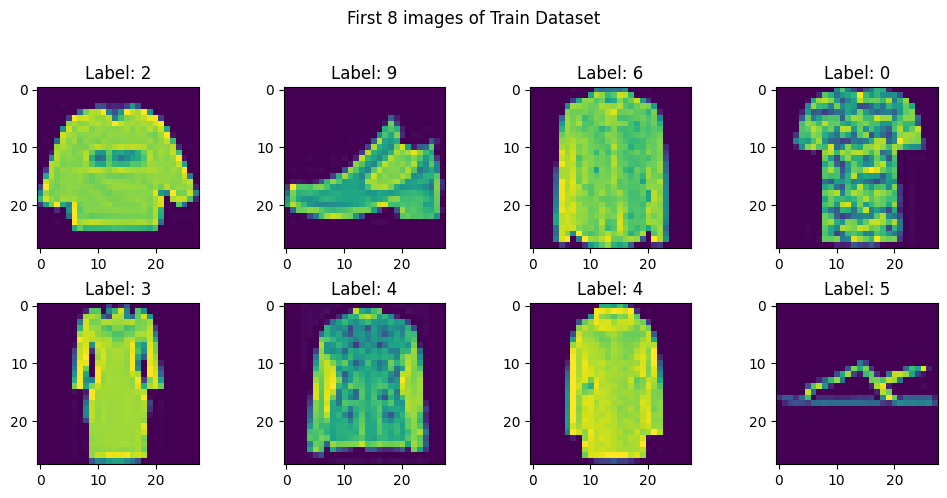

In [4]:
# create 4x4 grid of images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle("First 8 images of Train Dataset")

# plot first 8 images from the train dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28) # 28 x 28 img size
    ax.imshow(img)
    ax.set_title(f"Label: {df.iloc[i, 0]}")
plt.tight_layout(rect=[0,0,1,0.96]) # adjusting layout to fit the title
plt.show()

In [5]:
# train, val, test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

print(f"Train Data Size: {X_train.shape}")
print(f"Val Data Size: {X_val.shape}")
print(f"Test Data Size: {X_test.shape}")

Train Data Size: (48000, 784)
Val Data Size: (12000, 784)
Test Data Size: (10000, 784)


# Pretrain VGG16 Model Training Steps:
- Importing the pretrain model
- Detached the Classifier
- Attach new Classiifer
- Freeze the Feature Extraction Layers
- Reshape the Data for Model into 28x28
- Change the Data Type into np.uint8
- Change the Dimention into 1D to 3D (3x28x28)
- Convert the Data from Tensor to PIL image
- Resize the Data into 3x256x256
- Centro Crop (3x224x224)
- Scale the Tensor 0 to 1
- Normalize the channels with mean and std
- Train the Model

## Dataset Class

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class VGGDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # resize to (28, 28)
        X = self.X[idx].reshape(28, 28)
        y = self.y[idx]

        # change datatype to np.uint8
        X = X.astype(np.uint8)

        # change b&w to color -> (H,W,C) -> (C,H,W)
        X = np.stack([X]*3, axis=-1)

        # convert array to PIL Image
        X = Image.fromarray(X)

        # apply transforms
        X = self.transform(X)

        return X, y

## Import VGG16 Model

In [8]:
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
train_dataset = VGGDataset(X_train, y_train, transform=transform)
val_dataset = VGGDataset(X_val, y_val, transform=transform)
test_dataset = VGGDataset(X_test, y_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [10]:
# freeze the feature weights
for param in model.features.parameters():
    param.required_grad=False

In [11]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [12]:
# replacing with custom classifier
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 10)
)
model = model.to(device)

In [13]:
# init model parameters
learning_rate = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [14]:
# training loop
model.train()
for epoch in range(epochs):
    losses = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        # forward pass
        pred = model(X)
        # calculate loss
        loss = criterion(pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update gradient
        optimizer.step()

        losses += loss.item()
    avg_loss = losses/len(train_dataloader)
    print(f"Epoch: {epoch+1}/{epochs} -> Loss: {avg_loss:.4f}")


Epoch: 1/10 -> Loss: 0.6201
Epoch: 2/10 -> Loss: 0.4929
Epoch: 3/10 -> Loss: 0.4438
Epoch: 4/10 -> Loss: 0.4104
Epoch: 5/10 -> Loss: 0.3828
Epoch: 6/10 -> Loss: 0.3486
Epoch: 7/10 -> Loss: 0.3626
Epoch: 8/10 -> Loss: 0.3421
Epoch: 9/10 -> Loss: 0.3243
Epoch: 10/10 -> Loss: 0.3116


In [15]:
def check_acc(model, data):
  # evaluate on data
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for X, y in data:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      _, predicted = torch.max(pred, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
  return (correct/total) * 100

print(f"Training Accuracy: {check_acc(model, train_dataloader):.2f}%")
print(f"Validation Accuracy: {check_acc(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {check_acc(model, test_dataloader):.2f}%")

Training Accuracy: 95.01%
Validation Accuracy: 91.06%
Test Accuracy: 91.04%


**Overfitting Issue**